In [19]:
import torch
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

1. 准备数据

In [20]:
batch_size = 64
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.1307,), (0.3081, ))]) # 归一化 mean std

train_dataset = datasets.MNIST(root='../dataset/mnist',
                               train=True, 
                               download=True, 
                               transform=transform)
test_dataset = datasets.MNIST(root='../dataset/mnist',
                               train=False, 
                               download=True, 
                               transform=transform)

train_loader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=batch_size)


In [21]:
next(iter(train_loader))[0].shape

torch.Size([64, 1, 28, 28])

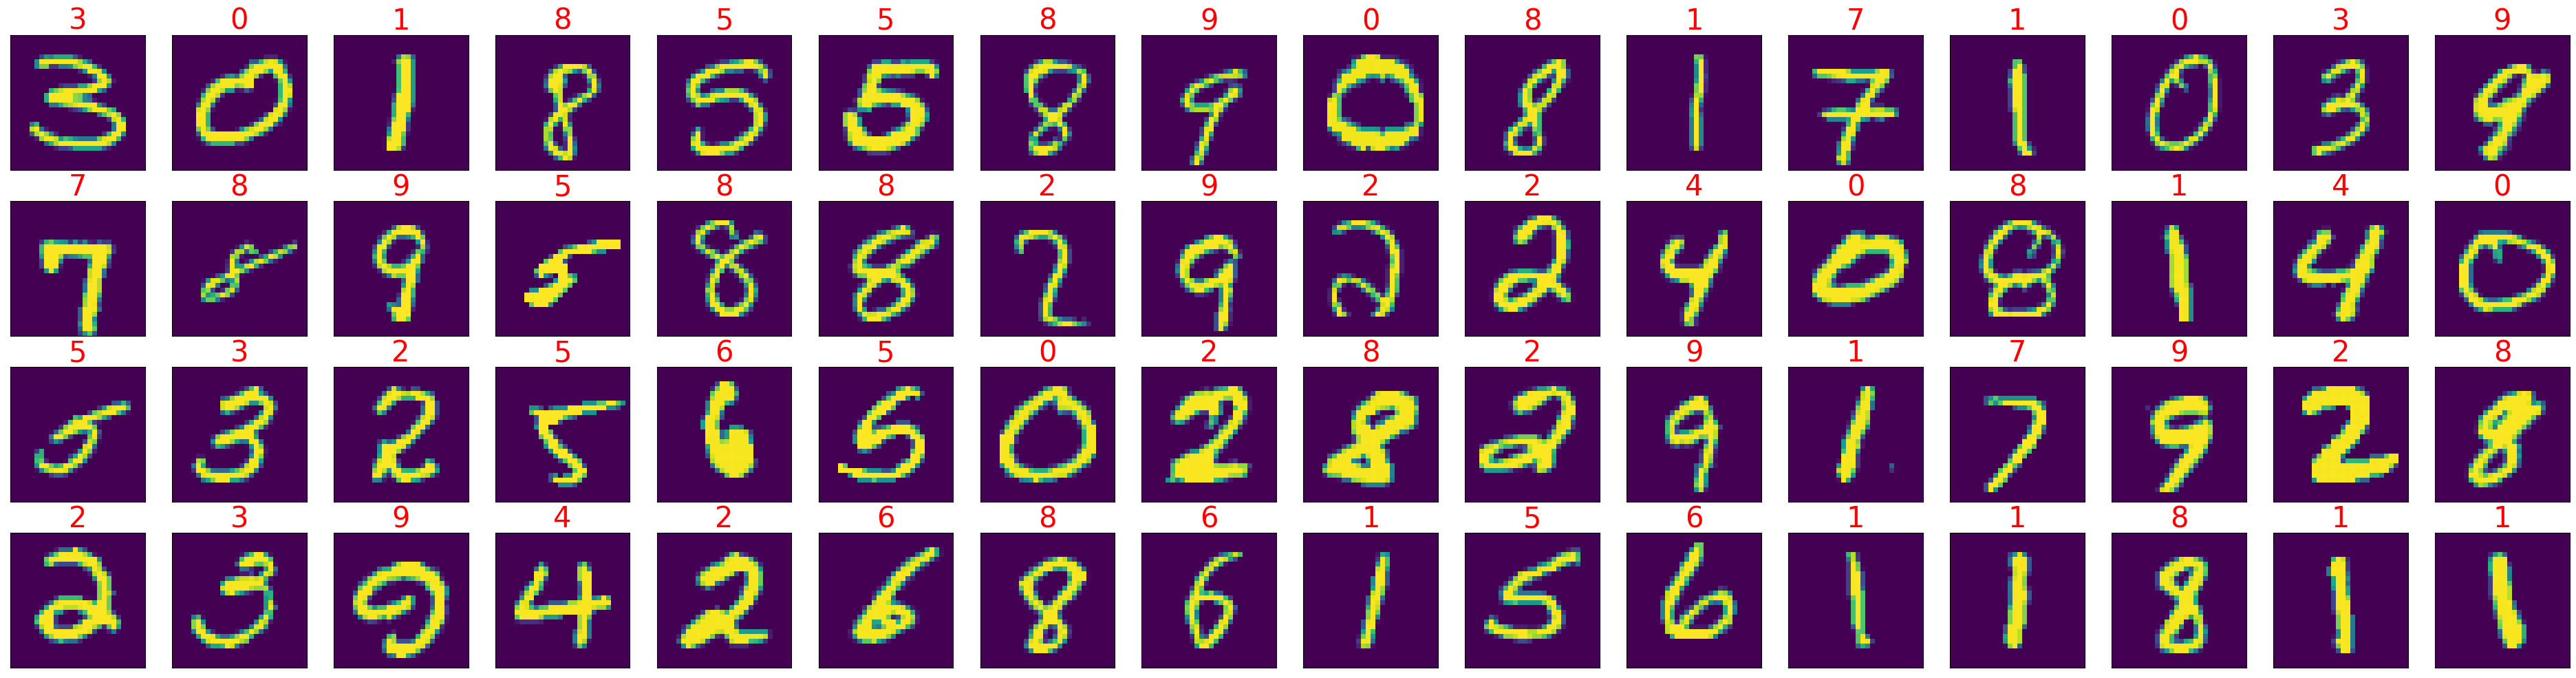

In [22]:
# 可视化
import numpy as np
import matplotlib.pyplot as plt

X, y = next(iter(train_loader))

fig, ax = plt.subplots(4,16, figsize=(3*16,3*4))
ax = ax.flatten()

for i, (ax, img, label) in enumerate(zip(ax, X.reshape(64,28,28), y)): # X本来为(64,1,28,28)
    ax.set_title(label.item(), size=30, color='r')
    ax.xaxis.set_visible(False) # 隐藏坐标轴
    ax.yaxis.set_visible(False) # 隐藏坐标轴
    ax.imshow(img.numpy())

2. 用类写模型

In [23]:
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.l1 = torch.nn.Linear(784, 512)
        self.l2 = torch.nn.Linear(512, 256)
        self.l3 = torch.nn.Linear(256, 128)
        self.l4 = torch.nn.Linear(128, 64)
        self.l5 = torch.nn.Linear(64, 10)
    
    def forward(self, x):
        x = x.reshape(-1,784)
        x = F.relu(self.l1(x))  # 每次经过linear后都需要用激活函数relu激活一下 
        x = F.relu(self.l2(x))
        x = F.relu(self.l3(x))
        x = F.relu(self.l4(x))
        return self.l5(x)  # 最后一层不用relu
    
model = Model()

3. 选取loss和optimizer

In [24]:
criterion = torch.nn.CrossEntropyLoss() # 包括softmax 和 loss(负对数)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5) # 带冲量

4. 训练与测试

In [25]:
def train(epoch):
    running_loss = 0.0
    for batch_idx, (inputs, target) in enumerate(train_loader): # 60000个样本被分为938个batch 一个batch_size=64
        # forward
        outputs = model(inputs)
        loss = criterion(outputs, target)
        # backward
        optimizer.zero_grad()
        loss.backward()
        # updata
        optimizer.step()
        
        running_loss += loss.item() # 累计loss
        if batch_idx % 300 == 299: # 每300次迭代输出一次
            print(f'epoch: {epoch+1}, batch_idx: {batch_idx+1} | loss: {running_loss/300:.3f}') # loss是一个batch的平均loss
            running_loss = 0

In [26]:
def test():
    correct = 0
    total = 0
    # test中无需计算梯度
    with torch.no_grad():
        for (inputs, labels) in test_loader:
            outputs = model(inputs)
            max_value, max_index = torch.max(outputs.data, dim=1) # 返回的是(这一行最大值，这一行最大值下标)
            total += labels.size(0) # 样本数；label(N,1)
            correct += (max_index==labels).sum().item()
    print(f'Accuracy on test set: {100*correct/total}%')


训练测试

In [27]:
for i in range(10): # 10个epoch 10轮训练和测试
    train(i)
    test()

epoch: 1, batch_idx: 300 | loss: 2.185
epoch: 1, batch_idx: 600 | loss: 0.883
epoch: 1, batch_idx: 900 | loss: 0.442
Accuracy on test set: 89.28%
epoch: 2, batch_idx: 300 | loss: 0.335
epoch: 2, batch_idx: 600 | loss: 0.283
epoch: 2, batch_idx: 900 | loss: 0.236
Accuracy on test set: 93.28%
epoch: 3, batch_idx: 300 | loss: 0.193
epoch: 3, batch_idx: 600 | loss: 0.178
epoch: 3, batch_idx: 900 | loss: 0.158
Accuracy on test set: 95.75%
epoch: 4, batch_idx: 300 | loss: 0.129
epoch: 4, batch_idx: 600 | loss: 0.127
epoch: 4, batch_idx: 900 | loss: 0.121
Accuracy on test set: 96.41%
epoch: 5, batch_idx: 300 | loss: 0.095
epoch: 5, batch_idx: 600 | loss: 0.097
epoch: 5, batch_idx: 900 | loss: 0.097
Accuracy on test set: 96.75%
epoch: 6, batch_idx: 300 | loss: 0.078
epoch: 6, batch_idx: 600 | loss: 0.076
epoch: 6, batch_idx: 900 | loss: 0.075
Accuracy on test set: 96.9%
epoch: 7, batch_idx: 300 | loss: 0.062
epoch: 7, batch_idx: 600 | loss: 0.059
epoch: 7, batch_idx: 900 | loss: 0.065
Accuracy